In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
17723,My hubby considers himself a hot sauce expert....,We love Tenessee Red Lightnin'
11937,"These aren't grandma's cookies, but tasty enou...",Good quick snack or breakfast
73361,"I've been craving some good taffy for a while,...",No thanks....
72674,"My dogs eat just about anything, but only 1 of...",2 stars for a 20% product
74682,Great product. My dog loves the bones and the...,My dog loves them
41528,These are my Yorkipoo and Shih-Tzu's favorite ...,My toy dogs LOVE these treats!
36058,We have looked far and wide for a gluten free ...,the best pizza crust mix ever!!!
45665,"As a hot drink, this made a great alternative ...",Tasty
2809,I ordered this Pack of 20 1-pound full leaf te...,"Not full leaf, 1 pound, not 20 pounds"
6903,"Unlike another product I reviewed for Vine, at...","Questionable ""healthy"" drink..."


# 데이터 전처리

중복과 NULL 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
print(data.isnull().sum())
data.head()

Text       0
Summary    1
dtype: int64


,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


텍스트 정규화 & 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터전처리

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


멀티프로세싱을 이용한 데이터 전처리

In [13]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['Summary'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

546.310090303421  seconds
['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo'
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch'
 ...
 'favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack'
 'like noodles although say spicy somewhat understatement one else family tolerates spicy well seeing looking forward extra little something palate disappointed completely honest usually drain liquid almost much'
 'love noodle twice week amazing thing feel well 

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


12.168606281280518  seconds
['good quality dog food' 'not as advertised' 'delight says it all' ...
 'great ramen' 'spicy'
 'this spicy noodle cures my cold upset stomach and headache every time']


불용어 제거후 빈 샘플 확인

In [14]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


샘플의 최대 길이 정하기

In [17]:
s = data['Summary'][0]
s.split()

['good', 'quality', 'dog', 'food']

In [18]:
text_max_len = 50
summary_max_len = 8

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [21]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


시작토큰과 종료토큰 추가하기

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [23]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

샘플 섞기

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[26860  1796  5152 ...  6923  4897 14571]


In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

train test dataset split

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


## 단어 집합 만들기 및 정수 인코딩

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

낮은 빈도수 단어 통계

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31963
등장 빈도가 6번 이하인 희귀 단어의 수: 23719
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8244
단어 집합에서 희귀 단어의 비율: 74.20767762725652
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3861869319339757


단어집합 만들기

In [30]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[34, 162, 1018, 14, 115, 185, 162, 166, 375, 159, 1283, 619, 445, 9, 1973, 244, 246, 94, 185, 162, 117, 37, 45, 250], [6, 755, 1013, 7, 57, 1438, 273, 34, 61, 250, 57, 78, 1438, 273, 232, 2146, 61, 2305, 66, 869, 230, 1195, 232, 2146, 62, 28, 3, 224], [882, 44, 157, 1314, 9, 1252, 12, 4, 1, 2970, 2886, 44, 61, 125, 199, 12, 234, 65, 3, 365, 6171, 384, 1409, 17, 44]]


summary데이터에도 동일한 작업 수행

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10522
등장 빈도가 5번 이하인 희귀 단어의 수: 8131
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2391
단어 집합에서 희귀 단어의 비율: 77.27618323512641
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.897980185060001


In [36]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 318, 1358, 240], [1, 5, 8, 51, 1663], [1, 59, 31, 1097], [1, 38, 58, 10, 98, 64, 223], [1, 247]]
target
decoder  [[318, 1358, 240, 2], [5, 8, 51, 1663, 2], [59, 31, 1097, 2], [38, 58, 10, 98, 64, 223, 2], [247, 2]]


빈도가 낮은 단어로만 구성되어서 null이 된 데이터 삭제.
bos, eos 토큰만 남아있을 것이므로 sentence len 이 1이다

In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1278
삭제할 테스트 데이터의 개수 : 341
훈련 데이터의 개수 : 51377
훈련 레이블의 개수 : 51377
테스트 데이터의 개수 : 12822
테스트 레이블의 개수 : 12822


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩추가

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 모델설계하기

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

어텐션 추가

In [42]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [43]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 모델 학습하기

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 52s 209ms/step - loss: 3.1328 - val_loss: 2.4326
Epoch 2/50
201/201 [==============================] - 40s 200ms/step - loss: 2.4166 - val_loss: 2.3088
Epoch 3/50
201/201 [==============================] - 41s 202ms/step - loss: 2.2801 - val_loss: 2.1665
Epoch 4/50
201/201 [==============================] - 41s 204ms/step - loss: 2.1356 - val_loss: 2.0743
Epoch 5/50
201/201 [==============================] - 41s 202ms/step - loss: 2.0418 - val_loss: 2.0177
Epoch 6/50
201/201 [==============================] - 42s 209ms/step - loss: 1.9583 - val_loss: 1.9772
Epoch 7/50
201/201 [==============================] - 43s 213ms/step - loss: 1.9018 - val_loss: 1.9498
Epoch 8/50
201/201 [==============================] - 42s 210ms/step - loss: 1.8502 - val_loss: 1.9222
Epoch 9/50
201/201 [==============================] - 41s 203ms/step - loss: 1.8104 - val_loss: 1.9101
Epoch 10/50
201/201 [==============================] - 41s 202ms/step - l

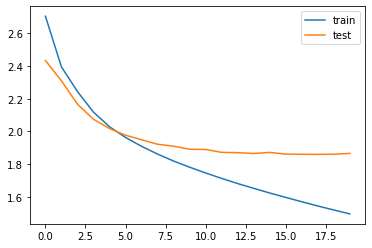

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Inference 모델 구현

복원을 위한 사전 정의

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

## 모델정의

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 모델 테스트

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [52]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : much good thing worked kibble time slowly percentage national junk food brand bowl natural time cats could keep mess moved 
실제 요약 : the cats 
예측 요약 :  my cats love it


원문 : good brings back old times problem wafers thinner slightly harder remember close get idea chocolate drops top colorful foil cardboard tube still brings back nice memories 
실제 요약 : good 
예측 요약 :  great chocolate


원문 : cheez best cheese cracker market today superior goldfish always superior cheese strongest flavor brand market 
실제 요약 : cheez it all 
예측 요약 :  best cheese crackers ever


원문 : dog years old product part wonderful walks like yrs old thanks 
실제 요약 : wonderful natural product for older dogs 
예측 요약 :  dog loves it


원문 : tried tea introduction rooibos excited hearing benefits rooibos dissapointment thought tea disgusting luckily give tried brands rooibos fantastic tea stale vanilla taste completely covers natural flavor rooibos stay away tea plain rooibos without added flavors perfect 
실제 요약 : worst r